In [1]:
import numpy as np
import matplotlib.pyplot as plt
from math import comb
import pandas as pd
import scipy
import scipy.optimize
from scipy.optimize import least_squares
from scipy.stats import norm

## Activity 1

In [29]:
## Object to simulate a 100 coin tosses. 
class CoinToss():
    '''
    Input p : probability of heads
    '''
    def __init__(self,p):
        self.p = p
        self.samples = np.random.binomial(size = 100, n=1, p=self.p)
    def nheads(self):
        return int(np.sum(self.samples))
    def p_mle(self):
        return self.nheads()/100

In [30]:
def log_likelihood(p,k):
    ''' 
    Input parameters:
    p - probability of heads
    k - number of heads obtained in the data
    '''
    N = 100
    N_choose_k = float(comb(int(N),int(k)))
    return (np.log(N_choose_k) + k*np.log(p) 
            + (N-k)*np.log(1-p))

In [31]:
## Set a true value for p
p_true = 0.5

In [35]:
trial = CoinToss(p_true)
print(trial.nheads())
print('p_fit = ', trial.p_mle())
print('p_true = ', trial.p)

47
p_fit =  0.47
p_true =  0.5


In [44]:
## The roots of the error_estimate function are the values of p
## such that log(L(p)) = log(L_max) - 0.5
def error_estimate(p):
    return (log_likelihood(p,trial.nheads())
            -log_likelihood(0.5,trial.nheads())
            +0.5)
uncertainities = scipy.optimize.fsolve(error_estimate,[0.45,0.53])
print('The uncertainities in the p_fit is given by')
print(uncertainities)

The uncertainities in the p_fit is given by
[0.4122589  0.52828297]


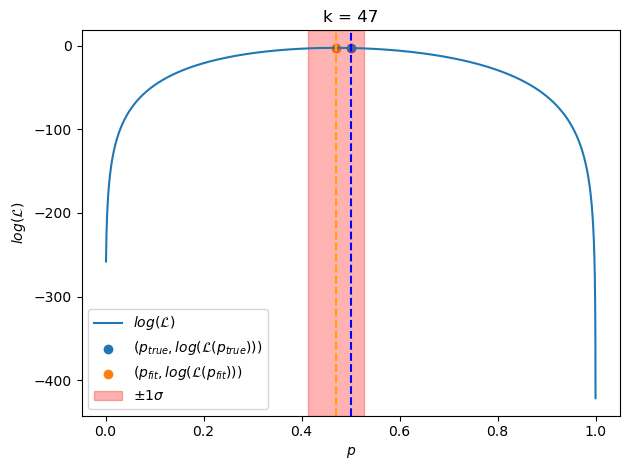

In [46]:
p_array = np.linspace(0.001,1,10000,endpoint=False,)
plt.plot(p_array,log_likelihood(p_array,trial.nheads()),
         label=r'$log(\mathcal{L})$')
plt.scatter(p_true,log_likelihood(p_true,trial.nheads()),
            label=r'$(p_{true},log(\mathcal{L}(p_{true})))$')
plt.scatter(trial.p_mle(),log_likelihood(trial.p_mle(),trial.nheads()),
            label=r'$(p_{fit},log(\mathcal{L}(p_{fit})))$')
plt.axvline(p_true,color='blue',linestyle='--')
plt.axvline(trial.p_mle(),color='orange',linestyle='--')
plt.axvspan(uncertainities[0],uncertainities[1],
            color='red',alpha=0.3,label=r'$\pm 1 \sigma$')
plt.xlabel(r'$p$')
plt.ylabel(r'$log(\mathcal{L})$')
plt.title(f'k = {trial.nheads()}')
plt.legend()
plt.tight_layout()
plt.savefig('mod3_act1.png',dpi=300)

## Activity 2

In [90]:
## Read file and save data as dictionary
df = pd.read_csv('Activity3.csv', header = None)
data = { 
    'time' : df[0].to_numpy(),
    'count' : df[1].to_numpy(),
    'uncertainity' : df[2].to_numpy()
}

In [91]:
## The exponential function
def count(t,w1,w2,w3,s1,s2):
    return w1*np.e**(-s1*t) + w2*np.e**(-s2*t) + w3*t


In [92]:
## The scaled function to be fit
def fit_func(x,w1,w2,w3,s1,s2):
    return w1*x**(s1) + w2*x**(s2) - w3*np.log(x)

In [93]:
## Scaled array
x = np.e**(-data['time']/100)

In [94]:
## Curve fit 
import scipy.optimize
guess_params = [1,1,1,1,1]
params_fit, params_fit_cov = scipy.optimize.curve_fit(fit_func,x,data['count'],
                                              p0=guess_params)

In [95]:
## Save params in the original scale
params = {
    'w1' : params_fit[0],
    'w2' : params_fit[1],
    'w3' : params_fit[2]/100,
    's1' : params_fit[3]/100,
    's2' : params_fit[4]/100
}

for k in params.keys():
    print(k, params[k])

w1 979.8231990657586
w2 169.623923891022
w3 0.015047781078455502
s1 0.03227154926522831
s2 0.0050199567539380326


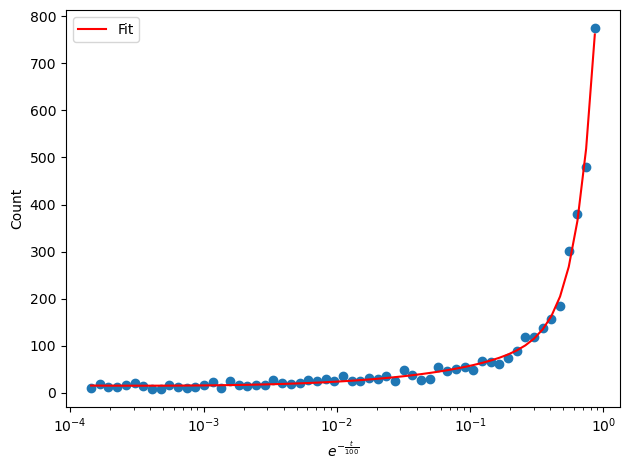

In [96]:
plt.scatter(x, data['count'])
plt.plot(x, fit_func(x, *params_fit), label = 'Fit',color='red')
plt.xscale('log')
plt.xlabel(r'$e^{- \frac{t}{100}}$')
plt.ylabel(r'Count')
plt.legend()
plt.tight_layout()
plt.savefig('mod3_act2_fig1.png', dpi = 300)

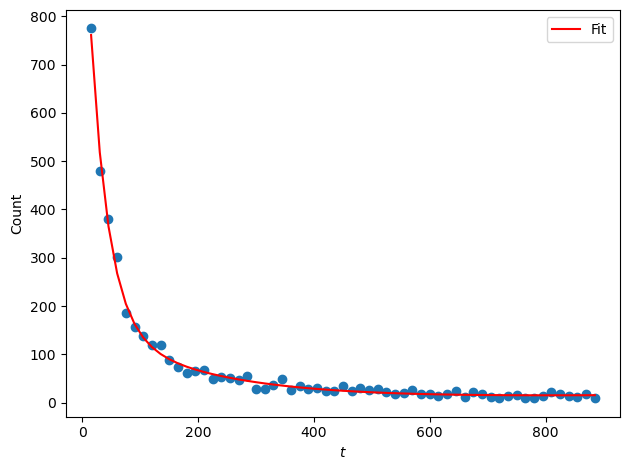

In [97]:
plt.plot(data['time'], count(data['time'],**params),label='Fit',color='red')
plt.scatter(data['time'], data['count'])
plt.xlabel(r'$t$')
plt.ylabel(r'Count')
plt.legend()
plt.tight_layout()
plt.savefig('mod3_act2_fig2.png', dpi = 300)

In [103]:
import scipy.stats


pull = data['count'] - count(data['count'],**params)/data['uncertainity']
variance = (data['count'] - count(data['count'],**params))**2
chi_square = np.sum(variance/count(data['count'],**params))
print('chi-square = ', chi_square)
dof = len(data['time']) - len(params_fit)
pval = 1 - scipy.stats.chi2.cdf(chi_square,dof)
print('p-value = ', pval)
        

chi-square =  79754.421969401
p-value =  0.0


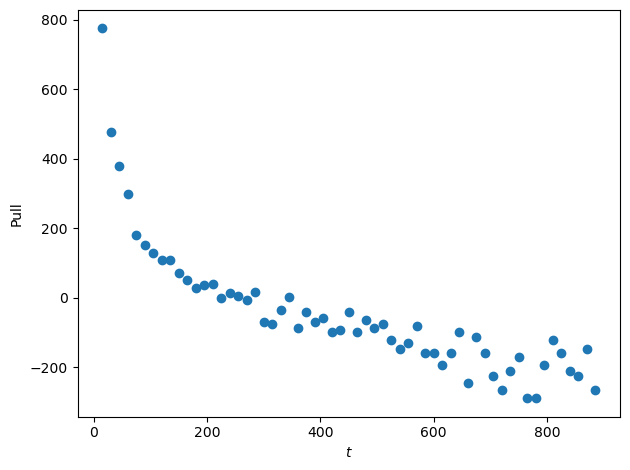

In [99]:
plt.scatter(data['time'], pull)
plt.xlabel(r'$t$')
plt.ylabel('Pull')

plt.tight_layout()
plt.savefig('mod3_act2_fig3.png', dpi=300)

## Activity 3

In [5]:


# Data generation function
def generate_data(samples=1000, p=0.5, noise_std=0.1):
    X = np.random.binomial(1, p, samples)
    # Add some noise and non-linearity to make the problem more interesting
    y = X + np.sin(X * 2) + np.random.normal(0, noise_std, samples)
    return X.reshape(-1, 1), y

# Polynomial basis functions
def polynomial_basis(X, degree=11):
    X = X.flatten()
    return np.vstack([X**i for i in range(degree+1)]).T

# Gaussian basis functions
def gaussian_basis(X, num_centers=11):
    X = X.flatten()
    centers = np.linspace(np.min(X), np.max(X), num_centers)
    width = (centers[1] - centers[0]) if len(centers) > 1 else 1.0
    return np.vstack([norm.pdf(X, loc=center, scale=width) for center in centers]).T

# Sigmoidal basis functions
def sigmoid_basis(X, num_centers=11):
    X = X.flatten()
    centers = np.linspace(np.min(X), np.max(X), num_centers)
    width = (centers[1] - centers[0]) if len(centers) > 1 else 1.0
    return np.vstack([1 / (1 + np.exp(-(X - center) / width)) for center in centers]).T

# Least squares fitting function
def fit_model(X, y, basis_func, **basis_params):
    phi = basis_func(X, **basis_params)
    # Use np.linalg.lstsq for direct solution of least squares
    weights, residuals, rank, s = np.linalg.lstsq(phi, y, rcond=None)
    return weights

# Prediction function
def predict(X, weights, basis_func, **basis_params):
    phi = basis_func(X, **basis_params)
    return phi @ weights

# Bayesian Linear Regression
def bayesian_linear_regression(X, y, basis_func, alpha=1.0, beta=1.0, **basis_params):
    phi = basis_func(X, **basis_params)
    S_N_inv = alpha * np.eye(phi.shape[1]) + beta * phi.T @ phi
    S_N = np.linalg.inv(S_N_inv)
    m_N = beta * S_N @ phi.T @ y
    return m_N, S_N

# Function to evaluate model performance
def evaluate_model(X_train, y_train, X_test, y_test, weights, basis_func, **basis_params):
    y_pred_train = predict(X_train, weights, basis_func, **basis_params)
    y_pred_test = predict(X_test, weights, basis_func, **basis_params)
    
    train_mse = np.mean((y_train - y_pred_train) ** 2)
    test_mse = np.mean((y_test - y_pred_test) ** 2)
    
    return train_mse, test_mse

# Main execution
if __name__ == "__main__":
    # Generate data
    np.random.seed(42)
    X, y = generate_data(samples=1000)
    
    # Split into train and test sets
    train_idx = np.random.choice(len(X), int(0.8*len(X)), replace=False)
    test_idx = np.array(list(set(range(len(X))) - set(train_idx)))
    
    X_train, y_train = X[train_idx], y[train_idx]
    X_test, y_test = X[test_idx], y[test_idx]
    
    # Dictionary to store results
    results = {}
    
    # 1. Polynomial Model
    poly_weights = fit_model(X_train, y_train, polynomial_basis)
    poly_train_mse, poly_test_mse = evaluate_model(
        X_train, y_train, X_test, y_test, 
        poly_weights, polynomial_basis
    )
    results['polynomial'] = (poly_train_mse, poly_test_mse)
    
    # 2. Gaussian Model
    gauss_weights = fit_model(X_train, y_train, gaussian_basis)
    gauss_train_mse, gauss_test_mse = evaluate_model(
        X_train, y_train, X_test, y_test, 
        gauss_weights, gaussian_basis
    )
    results['gaussian'] = (gauss_train_mse, gauss_test_mse)
    
    # 3. Sigmoidal Model
    sigmoid_weights = fit_model(X_train, y_train, sigmoid_basis)
    sigmoid_train_mse, sigmoid_test_mse = evaluate_model(
        X_train, y_train, X_test, y_test, 
        sigmoid_weights, sigmoid_basis
    )
    results['sigmoid'] = (sigmoid_train_mse, sigmoid_test_mse)
    
    # Print results
    print("\nModel Performance Summary:")
    print("-" * 50)
    for model_name, (train_mse, test_mse) in results.items():
        print(f"{model_name.capitalize()} Model:")
        print(f"Training MSE: {train_mse:.4f}")
        print(f"Test MSE: {test_mse:.4f}\n")
        
    # Bayesian Linear Regression for all three models
    print("\nBayesian Linear Regression Results:")
    print("-" * 50)
    for basis_func in [polynomial_basis, gaussian_basis, sigmoid_basis]:
        m_N, S_N = bayesian_linear_regression(X_train, y_train, basis_func)
        y_pred = predict(X_test, m_N, basis_func)
        mse = np.mean((y_test - y_pred) ** 2)
        print(f"{basis_func.__name__}:")
        print(f"Test MSE: {mse:.4f}\n")


Model Performance Summary:
--------------------------------------------------
Polynomial Model:
Training MSE: 0.0096
Test MSE: 0.0103

Gaussian Model:
Training MSE: 0.0096
Test MSE: 0.0103

Sigmoid Model:
Training MSE: 0.0096
Test MSE: 0.0103


Bayesian Linear Regression Results:
--------------------------------------------------
polynomial_basis:
Test MSE: 0.0103

gaussian_basis:
Test MSE: 0.0103

sigmoid_basis:
Test MSE: 0.0104



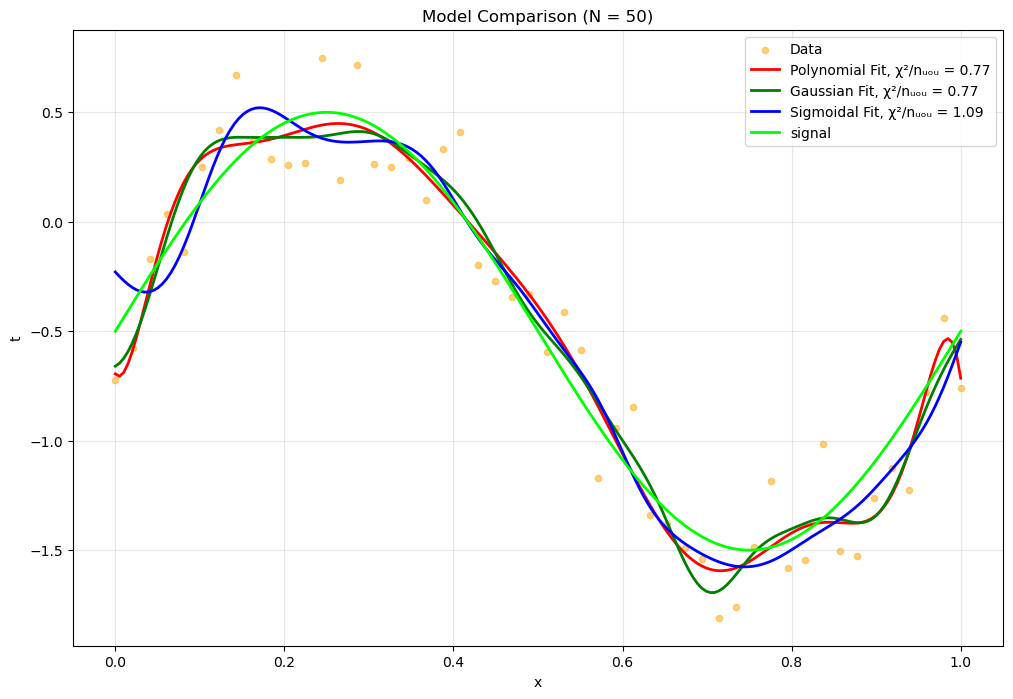

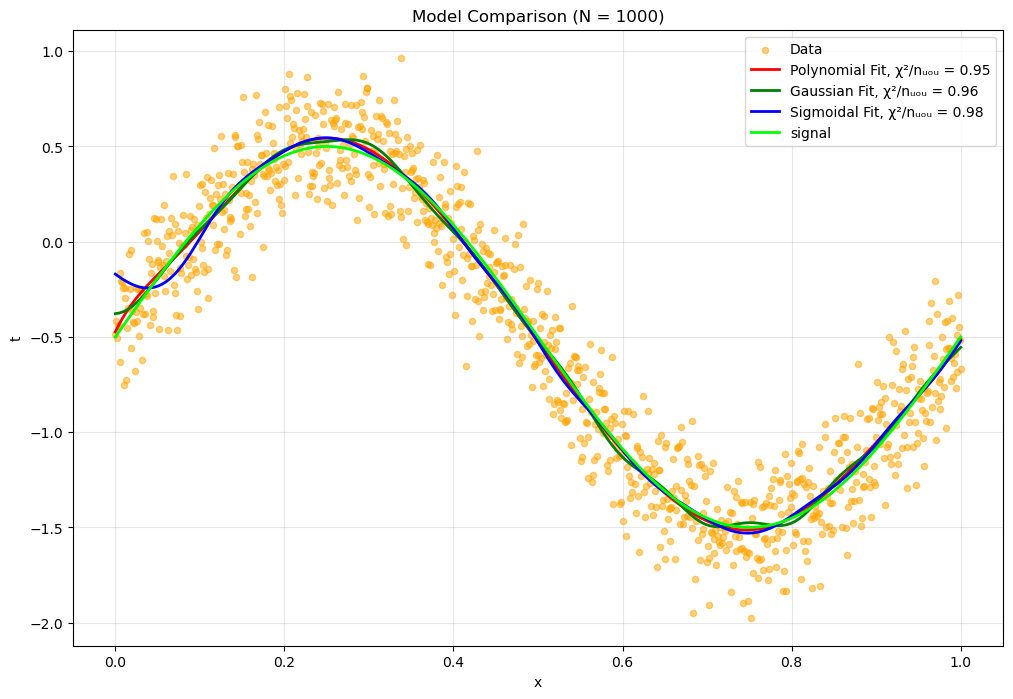

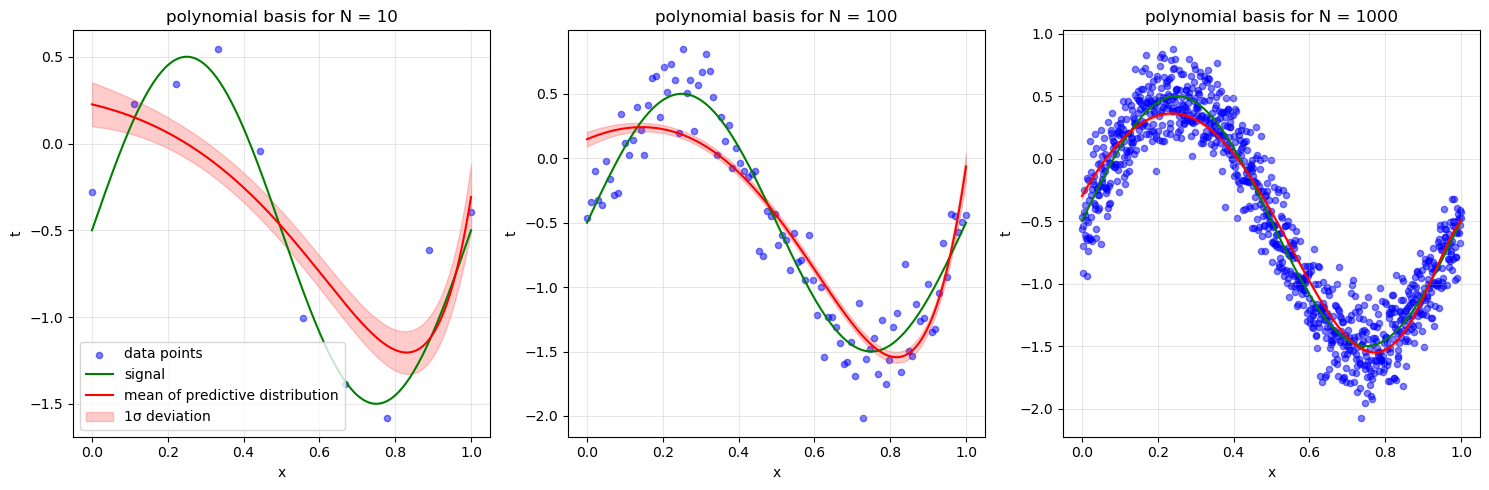

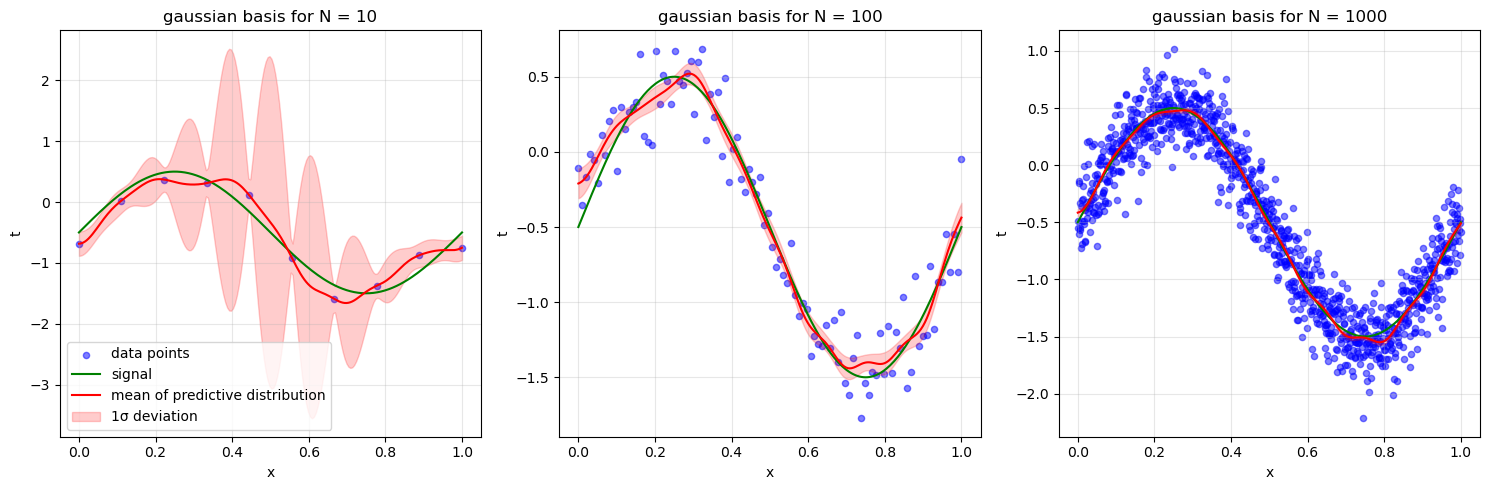

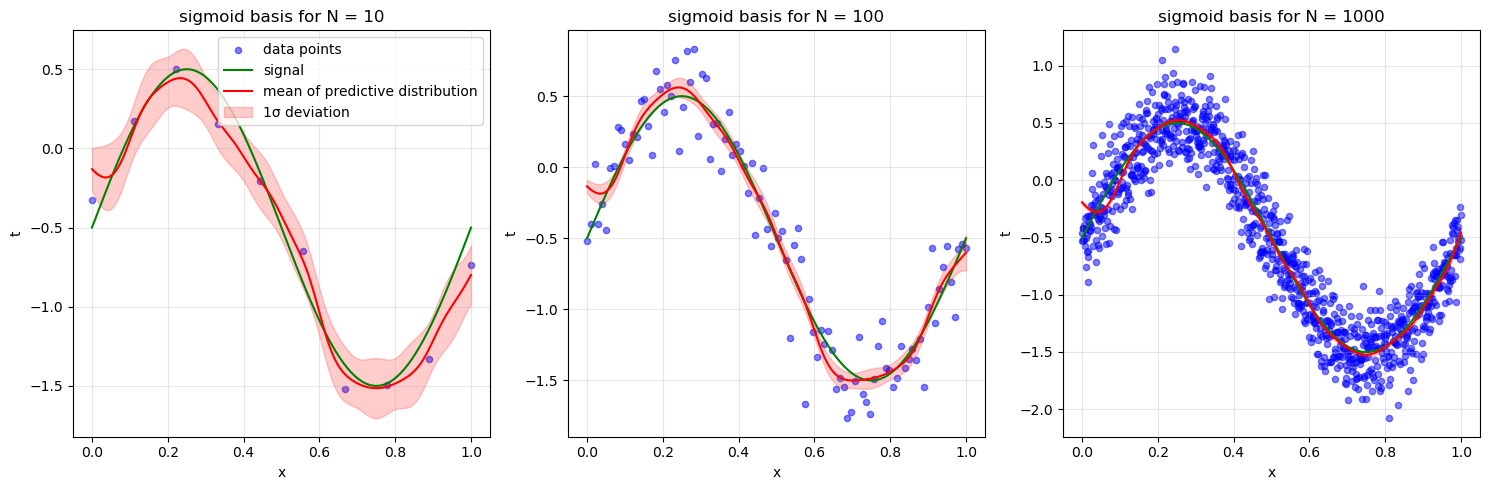

In [9]:
import numpy as np
from scipy.optimize import least_squares
from scipy.stats import norm, chi2
import matplotlib.pyplot as plt

def generate_data(N, noise_std=0.2):
    """Generate synthetic data with a known underlying signal"""
    X = np.linspace(0, 1, N)
    # True signal function (similar to the example)
    true_signal = np.sin(2 * np.pi * X) - 0.5
    # Add noise to create observations
    y = true_signal + np.random.normal(0, noise_std, N)
    return X.reshape(-1, 1), y, true_signal

def polynomial_basis(X, degree=11):
    """Polynomial basis functions"""
    X = X.flatten()
    return np.vstack([X**i for i in range(degree+1)]).T

def gaussian_basis(X, num_centers=11):
    """Gaussian basis functions"""
    X = X.flatten()
    centers = np.linspace(np.min(X), np.max(X), num_centers)
    width = (centers[1] - centers[0]) if len(centers) > 1 else 1.0
    return np.vstack([norm.pdf(X, loc=center, scale=width/2) for center in centers]).T

def sigmoid_basis(X, num_centers=11):
    """Sigmoidal basis functions"""
    X = X.flatten()
    centers = np.linspace(np.min(X), np.max(X), num_centers)
    width = (centers[1] - centers[0]) if len(centers) > 1 else 1.0
    return np.vstack([1 / (1 + np.exp(-(X - center)/(width/4))) for center in centers]).T

def fit_model(X, y, basis_func, **basis_params):
    """Fit model using least squares"""
    phi = basis_func(X, **basis_params)
    weights = np.linalg.lstsq(phi, y, rcond=None)[0]
    return weights

def calculate_chi_square(y_true, y_pred, noise_std):
    """Calculate reduced chi-square statistic"""
    chi_sq = np.sum((y_true - y_pred)**2) / (noise_std**2)
    n_dof = len(y_true) - 1  # Assuming one parameter fitted
    return chi_sq / n_dof

def bayesian_linear_regression(X, y, basis_func, alpha=2.0, beta=25.0, **basis_params):
    """Perform Bayesian linear regression"""
    phi = basis_func(X, **basis_params)
    S_N_inv = alpha * np.eye(phi.shape[1]) + beta * phi.T @ phi
    S_N = np.linalg.inv(S_N_inv)
    m_N = beta * S_N @ phi.T @ y
    return m_N, S_N

def plot_comparison(N, noise_std=0.2):
    """Plot comparison of different basis functions for a given sample size"""
    # Generate data
    X, y, true_signal = generate_data(N, noise_std)
    X_plot = np.linspace(0, 1, 200).reshape(-1, 1)
    
    # Fit models
    basis_funcs = [polynomial_basis, gaussian_basis, sigmoid_basis]
    basis_names = ['Polynomial', 'Gaussian', 'Sigmoidal']
    colors = ['red', 'green', 'blue']
    
    plt.figure(figsize=(12, 8))
    plt.scatter(X, y, c='orange', alpha=0.5, label='Data', s=20)
    
    for basis_func, name, color in zip(basis_funcs, basis_names, colors):
        # Fit model
        weights = fit_model(X, y, basis_func)
        y_pred = basis_func(X_plot) @ weights
        
        # Calculate chi-square
        y_fit = basis_func(X) @ weights
        chi_sq = calculate_chi_square(y, y_fit, noise_std)
        
        plt.plot(X_plot, y_pred, color, label=f'{name} Fit, χ²/nᵤₒᵤ = {chi_sq:.2f}', linewidth=2)
    
    plt.plot(X_plot, np.sin(2 * np.pi * X_plot.flatten()) - 0.5, 'lime', label='signal', linewidth=2)
    plt.xlabel('x')
    plt.ylabel('t')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.title(f'Model Comparison (N = {N})')
    plt.show()

def plot_bayesian_analysis(basis_func, N_values=[10, 100, 1000], noise_std=0.2):
    """Plot Bayesian analysis for different sample sizes"""
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    for i, N in enumerate(N_values):
        # Generate data
        X, y, true_signal = generate_data(N, noise_std)
        X_plot = np.linspace(0, 1, 200).reshape(-1, 1)
        
        # Perform Bayesian regression
        m_N, S_N = bayesian_linear_regression(X, y, basis_func)
        
        # Calculate predictive distribution
        phi_plot = basis_func(X_plot)
        y_mean = phi_plot @ m_N
        y_var = np.diag(phi_plot @ S_N @ phi_plot.T)
        y_std = np.sqrt(y_var)
        
        # Plot
        ax = axes[i]
        ax.scatter(X, y, c='blue', alpha=0.5, s=20, label='data points')
        ax.plot(X_plot, np.sin(2 * np.pi * X_plot.flatten()) - 0.5, 'g-', label='signal')
        ax.plot(X_plot, y_mean, 'r-', label='mean of predictive distribution')
        ax.fill_between(X_plot.flatten(), 
                       y_mean - y_std, 
                       y_mean + y_std,
                       color='red', alpha=0.2, label='1σ deviation')
        
        ax.set_xlabel('x')
        ax.set_ylabel('t')
        ax.set_title(f'{basis_func.__name__.replace("_", " ")} for N = {N}')
        if i == 0:  # Only show legend for first plot
            ax.legend()
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Execute the analysis
if __name__ == "__main__":
    # Plot regular fits for different sample sizes
    for N in [50, 1000]:  # Similar to your example images
        plot_comparison(N)
    
    # Plot Bayesian analysis for each basis function
    for basis_func in [polynomial_basis, gaussian_basis, sigmoid_basis]:
        plot_bayesian_analysis(basis_func)